<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Authors: [Maria Sumarokova](https://www.linkedin.com/in/mariya-sumarokova-230b4054/), and [Yury Kashnitsky](https://www.linkedin.com/in/festline/). Translated and edited by Gleb Filatov, Aleksey Kiselev, [Anastasia Manokhina](https://www.linkedin.com/in/anastasiamanokhina/), [Egor Polusmak](https://www.linkedin.com/in/egor-polusmak/), and [Yuanyuan Pao](https://www.linkedin.com/in/yuanyuanpao/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

# <center> Assignment #3 (demo). Solution
## <center>  Decision trees with a toy task and the UCI Adult dataset 

Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution). Fill in the answers in the [web-form](https://docs.google.com/forms/d/1wfWYYoqXTkZNOPy1wpewACXaj2MZjBdLOL58htGWYBA/edit).

Let's start by loading all necessary libraries:

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import collections
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import Image
from io import StringIO
import pydotplus #pip install pydotplus

### Part 1. Toy dataset "Will They? Won't They?"

Your goal is to figure out how decision trees work by walking through a toy problem. While a single decision tree does not yield outstanding results, other performant algorithms like gradient boosting and random forests are based on the same idea. That is why knowing how decision trees work might be useful.

We'll go through a toy example of binary classification - Person A is deciding whether they will go on a second date with Person B. It will depend on their looks, eloquence, alcohol consumption (only for example), and how much money was spent on the first date.

#### Creating the dataset

In [2]:
# Create dataframe with dummy variables
def create_df(dic, feature_list):
    out = pd.DataFrame(dic)
    out = pd.concat([out, pd.get_dummies(out[feature_list])], axis = 1)
    out.drop(feature_list, axis = 1, inplace = True)
    return out

# Some feature values are present in train and absent in test and vice-versa.
def intersect_features(train, test):
    common_feat = list( set(train.keys()) & set(test.keys()))
    return train[common_feat], test[common_feat]

In [3]:
features = ['Looks', 'Alcoholic_beverage','Eloquence','Money_spent']

#### Training data

In [4]:
df_train = {}
df_train['Looks'] = ['handsome', 'handsome', 'handsome', 'repulsive',
                         'repulsive', 'repulsive', 'handsome'] 
df_train['Alcoholic_beverage'] = ['yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes']
df_train['Eloquence'] = ['high', 'low', 'average', 'average', 'low',
                                   'high', 'average']
df_train['Money_spent'] = ['lots', 'little', 'lots', 'little', 'lots',
                                  'lots', 'lots']
df_train['Will_go'] = LabelEncoder().fit_transform(['+', '-', '+', '-', '-', '+', '+'])

df_train = create_df(df_train, features)
df_train

,Will_go,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Eloquence_low,Money_spent_little,Money_spent_lots
0,0,1,0,0,1,0,1,0,0,1
1,1,1,0,0,1,0,0,1,1,0
2,0,1,0,1,0,1,0,0,0,1
3,1,0,1,1,0,1,0,0,1,0
4,1,0,1,0,1,0,0,1,0,1
5,0,0,1,0,1,0,1,0,0,1
6,0,1,0,0,1,1,0,0,0,1


#### Test data

In [5]:
df_test = {}
df_test['Looks'] = ['handsome', 'handsome', 'repulsive'] 
df_test['Alcoholic_beverage'] = ['no', 'yes', 'yes']
df_test['Eloquence'] = ['average', 'high', 'average']
df_test['Money_spent'] = ['lots', 'little', 'lots']
df_test = create_df(df_test, features)
df_test

,Looks_handsome,Looks_repulsive,Alcoholic_beverage_no,Alcoholic_beverage_yes,Eloquence_average,Eloquence_high,Money_spent_little,Money_spent_lots
0,1,0,1,0,1,0,0,1
1,1,0,0,1,0,1,1,0
2,0,1,0,1,1,0,0,1


In [6]:
# Some feature values are present in train and absent in test and vice-versa.
y = df_train['Will_go']
df_train, df_test = intersect_features(train=df_train, test=df_test)
df_train

,Money_spent_little,Money_spent_lots,Looks_repulsive,Eloquence_average,Looks_handsome,Eloquence_high,Alcoholic_beverage_yes,Alcoholic_beverage_no
0,0,1,0,0,1,1,1,0
1,1,0,0,0,1,0,1,0
2,0,1,0,1,1,0,0,1
3,1,0,1,1,0,0,0,1
4,0,1,1,0,0,0,1,0
5,0,1,1,0,0,1,1,0
6,0,1,0,1,1,0,1,0


In [7]:
df_test

,Money_spent_little,Money_spent_lots,Looks_repulsive,Eloquence_average,Looks_handsome,Eloquence_high,Alcoholic_beverage_yes,Alcoholic_beverage_no
0,0,1,0,1,1,0,0,1
1,1,0,0,0,1,1,1,0
2,0,1,1,1,0,0,1,0


#### Draw a decision tree (by hand or in any graphics editor) for this dataset. Optionally you can also implement tree construction and draw it here.

1\. What is the entropy $S_0$ of the initial system? By system states, we mean values of the binary feature "Will_go" - 0 or 1 - two states in total.

<font color='red'>Answer: </font>  $S_0 = -\frac{3}{7}\log_2{\frac{3}{7}}-\frac{4}{7}\log_2{\frac{4}{7}} = 0.985$.

2\. Let's split the data by the feature "Looks_handsome". What is the entropy $S_1$ of the left group - the one with "Looks_handsome". What is the entropy $S_2$ in the opposite group? What is the information gain (IG) if we consider such a split?

<font color='red'>Answer: </font> $S_1 = -\frac{1}{4}\log_2{\frac{1}{4}}-\frac{3}{4}\log_2{\frac{3}{4}} = 0.811$, $S_2 = -\frac{2}{3}\log_2{\frac{2}{3}}-\frac{1}{3}\log_2{\frac{1}{3}} = 0.918$, $IG = S_0-\frac{4}{7}S_1-\frac{3}{7}S_2 = 0.128$.

#### Train a decision tree using sklearn on the training data. You may choose any depth for the tree.

In [8]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=17)
dt.fit(df_train, y);

#### Additional: display the resulting tree using graphviz. You can use pydot or [web-service](https://www.coolutils.com/ru/online/DOT-to-PNG) dot2png.

In [9]:
dot_data = StringIO()
export_graphviz(dt, feature_names = df_train.columns, out_file=dot_data,
                filled=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(value=graph.create_png())

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xe5\x00\x00\x01\xdd\x08\x06\x00\x00\x00#\x19a\xa…

### Part 2. Functions for calculating entropy and information gain.

Consider the following warm-up example: we have 9 blue balls and 11 yellow balls. Let ball have label **1** if it is blue, **0** otherwise.

In [10]:
balls = [1 for i in range(9)] + [0 for i in range(11)]

<img src = '../../img/decision_tree3.png'>

Next split the balls into two groups:

<img src = '../../img/decision_tree4.png'>

In [11]:
# two groups
balls_left  = [1 for i in range(8)] + [0 for i in range(5)] # 8 blue and 5 yellow
balls_right = [1 for i in range(1)] + [0 for i in range(6)] # 1 blue and 6 yellow

#### Implement a function to calculate the Shannon Entropy

In [12]:
from math import log
    
def entropy(a_list):
    lst = list(a_list)
    size = len(lst) * 1.0
    entropy = 0
    set_elements = len(set(lst))
    if set_elements in [0,1]:
        return 0
    for i in set(lst):
        occ = lst.count(i)
        entropy -= occ/size * log (occ/size,2)
    return entropy

Tests

In [13]:
print(entropy(balls)) # 9 blue и 11 yellow
print(entropy(balls_left)) # 8 blue и 5 yellow
print(entropy(balls_right)) # 1 blue и 6 yellow
print(entropy([1,2,3,4,5,6])) # entropy of a fair 6-sided die

0.9927744539878084
0.961236604722876
0.5916727785823275
2.584962500721156


3\. What is the entropy of the state given by the list **balls_left**?

<font color='red'>Answer:</font> 0.961

4\. What is the entropy of a fair dice? (where we look at a dice as a system with 6 equally probable states)?

<font color='red'>Answer:</font> 2.585

In [14]:
# information gain calculation
def information_gain(root, left, right):
    ''' root - initial data, left and right - two partitions of initial data'''
        
    return entropy(root) - 1.0 * len(left) / len(root) * entropy(left) \
                         - 1.0 * len(right) / len(root) * entropy(right) 

In [15]:
print(information_gain(balls, balls_left, balls_right))

0.16088518841412436


5\. What is the information gain from splitting the initial dataset into **balls_left** and **balls_right** ?

<font color='red'>Answer:</font> 0.161

In [16]:
def information_gains(X, y):
    '''Outputs information gain when splitting with each feature'''
    out = []
    for i in X.columns:
        out.append(information_gain(y,y[X[i] == 0], y[X[i] == 1]))
    return out

#### Optional:
- Implement a decision tree building algorithm by calling `information_gains` recursively
- Plot the resulting tree

In [17]:
information_gains(df_train, y)

[0.46956521111470706,
 0.46956521111470706,
 0.12808527889139454,
 0.02024420715375619,
 0.12808527889139454,
 0.2916919971380598,
 0.005977711423774124,
 0.005977711423774124]

In [18]:
def btree(X,y):
    clf = information_gains(X, y)
    param = clf.index(max(clf))
    ly = y[X.iloc[:,param] == 0]
    ry = y[X.iloc[:,param] == 1]
    print ('Column_' + str(param) + ' N/Y?')
    print ('Entropy: ',entropy (ly), entropy (ry))
    print ('N count:',ly.count(),'/', 'Y count:',ry.count())
    if entropy (ly) != 0:
        left = X[X.iloc[:,param] == 0]
        btree(left, ly)
    if entropy (ry) != 0:
        right = X[X.iloc[:,param] == 1]
        btree(right, ry)

In [19]:
btree (df_train,y)

Column_0 N/Y?
Entropy:  0.7219280948873623 0
N count: 5 / Y count: 2
Column_2 N/Y?
Entropy:  0 1.0
N count: 3 / Y count: 2
Column_5 N/Y?
Entropy:  0 0
N count: 1 / Y count: 1


### Part 3. The "Adult" dataset

#### Dataset description:

[Dataset](http://archive.ics.uci.edu/ml/machine-learning-databases/adult) UCI Adult (no need to download it, we have a copy in the course repository): classify people using demographical data - whether they earn more than \$50,000 per year or not.

Feature descriptions:

- **Age** – continuous feature
- **Workclass** –  continuous feature
- **fnlwgt** – final weight of object, continuous feature
- **Education** –  categorical feature
- **Education_Num** – number of years of education, continuous feature
- **Martial_Status** –  categorical feature
- **Occupation** –  categorical feature
- **Relationship** – categorical feature
- **Race** – categorical feature
- **Sex** – categorical feature
- **Capital_Gain** – continuous feature
- **Capital_Loss** – continuous feature
- **Hours_per_week** – continuous feature
- **Country** – categorical feature

**Target** – earnings level, categorical (binary) feature.

#### Reading train and test data

In [20]:
data_train = pd.read_csv('../../data/adult_train.csv', sep=';')

In [21]:
data_train.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K
32560,52,Self-emp-inc,287927,HS-grad,9,Married-civ-spouse,Exec-managerial,Wife,White,Female,15024,0,40,United-States,>50K


In [22]:
data_test = pd.read_csv('../../data/adult_test.csv', sep=';')

In [23]:
data_test.tail()

,Age,Workclass,fnlwgt,Education,Education_Num,Martial_Status,Occupation,Relationship,Race,Sex,Capital_Gain,Capital_Loss,Hours_per_week,Country,Target
16277,39,Private,215419.0,Bachelors,13.0,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0.0,36.0,United-States,<=50K.
16278,64,NaN,321403.0,HS-grad,9.0,Widowed,NaN,Other-relative,Black,Male,0.0,0.0,40.0,United-States,<=50K.
16279,38,Private,374983.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
16280,44,Private,83891.0,Bachelors,13.0,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0.0,40.0,United-States,<=50K.
16281,35,Self-emp-inc,182148.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,60.0,United-States,>50K.


In [24]:
# necessary to remove rows with incorrect labels in test dataset
data_test = data_test[(data_test['Target'] == ' >50K.') | (data_test['Target']==' <=50K.')]

# encode target variable as integer
data_train.loc[data_train['Target']==' <=50K', 'Target'] = 0
data_train.loc[data_train['Target']==' >50K', 'Target'] = 1

data_test.loc[data_test['Target']==' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target']==' >50K.', 'Target'] = 1

#### Primary data analysis

In [25]:
data_test.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,16281,73,35,461,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Workclass,15318,8,Private,11210,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,16281,NaN,NaN,NaN,189436,105715,13492,116736,177831,238384,1.4904e+06
Education,16281,16,HS-grad,5283,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Education_Num,16281,NaN,NaN,NaN,10.0729,2.56755,1,9,10,12,16
Martial_Status,16281,7,Married-civ-spouse,7403,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,15315,14,Prof-specialty,2032,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relationship,16281,6,Husband,6523,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Race,16281,5,White,13946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sex,16281,2,Male,10860,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
data_train['Target'].value_counts()

0    24720
1     7841
Name: Target, dtype: int64

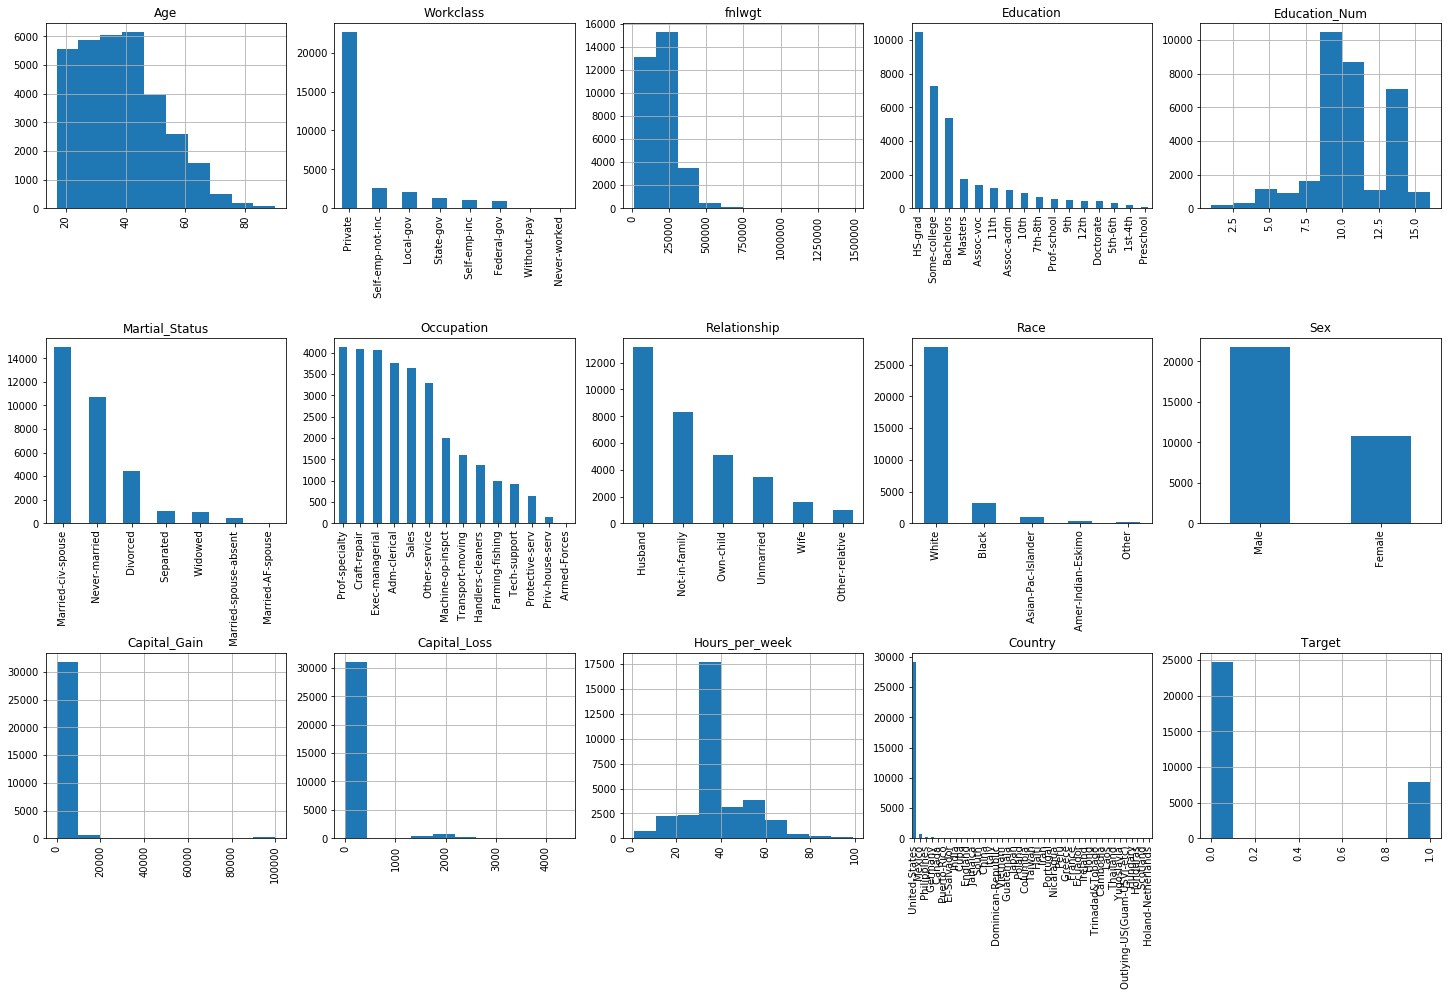

In [27]:
fig = plt.figure(figsize=(25, 15))
cols = 5
rows = np.ceil(float(data_train.shape[1]) / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == np.object:
        data_train[column].value_counts().plot(kind="bar", axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation="vertical")
plt.subplots_adjust(hspace=0.7, wspace=0.2)

#### Checking data types

In [28]:
data_train.dtypes

Age                int64
Workclass         object
fnlwgt             int64
Education         object
Education_Num      int64
Martial_Status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_Gain       int64
Capital_Loss       int64
Hours_per_week     int64
Country           object
Target             int64
dtype: object

In [29]:
data_test.dtypes

Age                object
Workclass          object
fnlwgt            float64
Education          object
Education_Num     float64
Martial_Status     object
Occupation         object
Relationship       object
Race               object
Sex                object
Capital_Gain      float64
Capital_Loss      float64
Hours_per_week    float64
Country            object
Target              int64
dtype: object

As we see, in the test data, age is treated as type **object**. We need to fix this.

In [30]:
data_test['Age'] = data_test['Age'].astype(int)

Also we'll cast all **float** features to **int** type to keep types consistent between our train and test data.

In [31]:
data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

#### Fill in missing data for continuous features with their median values, for categorical features with their mode.

In [32]:
# we see some missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         30725 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education_Num     32561 non-null int64
Martial_Status    32561 non-null object
Occupation        30718 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital_Gain      32561 non-null int64
Capital_Loss      32561 non-null int64
Hours_per_week    32561 non-null int64
Country           31978 non-null object
Target            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


In [33]:
# choose categorical and continuous features from data

categorical_columns = [c for c in data_train.columns 
                       if data_train[c].dtype.name == 'object']
numerical_columns = [c for c in data_train.columns 
                     if data_train[c].dtype.name != 'object']

print('categorical_columns:', categorical_columns)
print('numerical_columns:', numerical_columns)

categorical_columns: ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
numerical_columns: ['Age', 'fnlwgt', 'Education_Num', 'Capital_Gain', 'Capital_Loss', 'Hours_per_week', 'Target']


In [34]:
# fill missing data

for c in categorical_columns:
    data_train[c].fillna(data_train[c].mode()[0], inplace=True)
    data_test[c].fillna(data_train[c].mode()[0], inplace=True)
    
for c in numerical_columns:
    data_train[c].fillna(data_train[c].median(), inplace=True)
    data_test[c].fillna(data_train[c].median(), inplace=True)

In [35]:
# no more missing values
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
Age               32561 non-null int64
Workclass         32561 non-null object
fnlwgt            32561 non-null int64
Education         32561 non-null object
Education_Num     32561 non-null int64
Martial_Status    32561 non-null object
Occupation        32561 non-null object
Relationship      32561 non-null object
Race              32561 non-null object
Sex               32561 non-null object
Capital_Gain      32561 non-null int64
Capital_Loss      32561 non-null int64
Hours_per_week    32561 non-null int64
Country           32561 non-null object
Target            32561 non-null int64
dtypes: int64(7), object(8)
memory usage: 3.7+ MB


We'll dummy code some categorical features: **Workclass**, **Education**, **Martial_Status**, **Occupation**, **Relationship**, **Race**, **Sex**, **Country**. It can be done via pandas method **get_dummies**

In [36]:
data_train = pd.concat([data_train[numerical_columns],
    pd.get_dummies(data_train[categorical_columns])], axis=1)

data_test = pd.concat([data_test[numerical_columns],
    pd.get_dummies(data_test[categorical_columns])], axis=1)

In [37]:
set(data_train.columns) - set(data_test.columns)

{'Country_ Holand-Netherlands'}

In [38]:
data_train.shape, data_test.shape

((32561, 106), (16281, 105))

#### There is no Holland in the test data. Create new zero-valued feature.

In [39]:
data_test['Country_ Holand-Netherlands'] = 0

In [40]:
set(data_train.columns) - set(data_test.columns)

set()

In [41]:
data_train.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Portugal,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
data_test.head(2)

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Target,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holand-Netherlands
1,25,226802,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [43]:
X_train = data_train.drop(['Target'], axis=1)
y_train = data_train['Target']

X_test = data_test.drop(['Target'], axis=1)
y_test = data_test['Target']

### 3.1 Decision tree without parameter tuning

Train a decision tree **(DecisionTreeClassifier)** with a maximum depth of 3, and evaluate the accuracy metric on the test data. Use parameter **random_state = 17** for results reproducibility.

In [44]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=17, splitter='best')

Make a prediction with the trained model on the test data.

In [45]:
tree_predictions = tree.predict(X_test) 

In [46]:
accuracy_score(y_test,tree_predictions)

0.8447884036607088

6\. What is the test set accuracy of a decision tree with maximum tree depth of 3 and **random_state = 17**?

### 3.2 Decision tree with parameter tuning

Train a decision tree **(DecisionTreeClassifier, random_state = 17).** Find the optimal maximum depth using 5-fold cross-validation **(GridSearchCV)**.

In [47]:
%%time
tree_params = {'max_depth': range(2, 11)}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=17),
                                 tree_params, cv=5)                  

locally_best_tree.fit(X_train, y_train)

CPU times: user 20.8 s, sys: 598 ms, total: 21.4 s
Wall time: 5.52 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(2, 11)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=N

In [48]:
print("Best params:", locally_best_tree.best_params_)
print("Best cross validaton score", locally_best_tree.best_score_)

Best params: {'max_depth': 9}
Best cross validaton score 0.8565768864592611


Train a decision tree with maximum depth of 9 (it is the best **max_depth** in my case), and compute the test set accuracy. Use parameter **random_state = 17** for reproducibility.

In [49]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test)
accuracy_score(y_test, tuned_tree_predictions)

0.847798046803022

7\. What is the test set accuracy of a decision tree with maximum depth of 9 and **random_state = 17**?

<font color='red'>Answer:</font> 0.848

### 3.3 (Optional) Random forest without parameter tuning

Let's take a sneak peek of upcoming lectures and try to use a random forest for our task. For now, you can imagine a random forest as a bunch of decision trees, trained on slightly different subsets of the training data.

Train a random forest **(RandomForestClassifier)**. Set the number of trees to 100 and use **random_state = 17**.

In [50]:
rf = RandomForestClassifier(n_estimators=100, random_state=17)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

Perfrom cross-validation.

In [51]:
%%time
cv_scores = cross_val_score(rf, X_train, y_train, cv=3)

CPU times: user 10.7 s, sys: 190 ms, total: 10.9 s
Wall time: 9.2 s


In [52]:
cv_scores, cv_scores.mean()

(array([0.85194398, 0.85572139, 0.859578  ]), 0.8557477912289437)

Make predictions for the test data.

In [53]:
forest_predictions = rf.predict(X_test) 

In [54]:
accuracy_score(y_test,forest_predictions)

0.8585467723112831

### 3.4 (Optional) Random forest with parameter tuning

Train a random forest **(RandomForestClassifier)** of 10 trees. Tune the maximum depth and maximum number of features for each tree using **GridSearchCV**. 

In [55]:
forest_params = {'max_depth': range(10, 16),
                 'max_features': range(5, 105, 20)}

locally_best_forest = GridSearchCV(RandomForestClassifier(n_estimators=10, random_state=17,
                                                         n_jobs=-1),
                                   forest_params, cv=3, verbose=1)

locally_best_forest.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   33.0s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=-1,
                                              oob_score=False, random_state=17,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_de

In [56]:
print("Best params:", locally_best_forest.best_params_)
print("Best cross validaton score", locally_best_forest.best_score_)

Best params: {'max_depth': 14, 'max_features': 45}
Best cross validaton score 0.8619821258560855


Make predictions for the test data.

In [57]:
tuned_forest_predictions = locally_best_forest.predict(X_test) 
accuracy_score(y_test,tuned_forest_predictions)

0.8611264664332657

Wow! Looks that with some tuning we made a forest of 10 trees perform better than a forest of 100 trees with default hyperparameter values. 